<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Natural Language Processing

In [69]:
import tensorflow as tf

import pandas as pd

import random

from tensorflow.keras.layers import Embedding, TextVectorization

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Constantes

In [110]:
SEMENTE = 2008193
INDICES = range(8)

## Funções

In [3]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-27 21:38:57--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196 (5.1K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   5.07K  --.-KB/s    in 0s      

2023-01-27 21:38:58 (46.3 MB/s) - ‘funcoes.py’ saved [5196/5196]



In [4]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, unzip_data

In [131]:
def avaliar_modelo(previsao, validacao=y_test):
    print(classification_report(validacao, previsao))
    ConfusionMatrixDisplay.from_predictions(validacao, previsao, cmap='summer_r')

    relatorio = classification_report(validacao, previsao, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

## Dados

Dados originalmente da competição **Natural Language Processing with Disaster Tweets** no Kaggle. (Em andamento em 27.01.2023.)

https://www.kaggle.com/c/nlp-getting-started

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2023-01-27 21:38:59--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.008s  

2023-01-27 21:38:59 (73.6 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [6]:
df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

# Embaralhar dados de treino (frac=1 = 100% dos dados)
df_treino = df_treino.sample(frac=1, random_state=SEMENTE)

In [7]:
df_treino.head()

,id,keyword,location,text,target
2299,3299,demolish,NYHC,If you think going to demolish Drake's house o...,1
3704,5269,fear,Carregado,I didn`t want to hurt you but the fear drove m...,0
3468,4961,explosion,New York,New Explosion-proof Tempered Glass Screen Prot...,0
6653,9533,terrorist,????? ???? ????,#UdhampurAgain 2 terrorist shot dead.. #Udhampur,1
3634,5183,fatalities,jersey,mortal kombat fatalities are so gross but inte...,0


In [8]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 2299 to 4895
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB


In [9]:
df_treino['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Separar dados para validação

In [10]:
X = df_treino['text']
y = df_treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Converter texto em números

### Vetorização (Vectorization)

In [34]:
# # Valores-padrão para TextVectorization
# vetorizador = TextVectorization(max_tokens=None,                            # Máximo de tokens (palavras) no dicionário. (Palavras acima do limite são classificadas como OOV.)
#                                 standardize='lower_and_strip_punctuation',  # Texto em caixa baixa e retira caracteres especiais.
#                                 split='whitespace',                         # Separador de tokens.
#                                 ngrams=None,                                # Tokens por grupo. (None = não agrupar tokens.)
#                                 output_mode='int',                          # Como mapear tokens para números.
#                                 output_sequence_length=None)                # Tamanho da sequencia de tokens (texto), completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [12]:
limite_dicionario = 10000
media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))

vetorizador = TextVectorization(max_tokens=limite_dicionario,
                                output_mode='int',
                                output_sequence_length=media_palavras_por_texto)

In [13]:
vetorizador.adapt(X_train)

In [27]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

Maryland mansion fire that killed 6 caused by damaged plug under Christmas tree report says - Into the flames: Firefighter's bravery...


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[2390, 2393,   40,   16,  121,  478,  583,   18, 1421, 2033,  211,
        1908,  985,  338,  286]])>

In [32]:
vocabulario = vetorizador.get_vocabulary()

In [35]:
# [UNK] = OOV (out of vocabulary)
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pacic', 'p45perez', 'oyster', 'oworoshoki', 'ownership'])

### Incorporação (Embedding)

In [39]:
incorporador = Embedding(input_dim=limite_dicionario,            # Tamanho do vocabulário de entrada.
                         output_dim=128,                         # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=media_palavras_por_texto)  # Tamanho da sequencia de tokens de entrada.

In [52]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

Mad River Complex fires have burned 14028 acres 8% contained: The Mad River Complex fires in Trinity County ... http://t.co/LfNIPpNOtO


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02453264,  0.01234464,  0.04058788, ...,  0.03851265,
          0.00587586,  0.02509725],
        [ 0.04687444,  0.030391  , -0.03275967, ..., -0.0468074 ,
         -0.02541671, -0.02132734],
        [ 0.02828616, -0.00014802, -0.00894135, ..., -0.0192355 ,
         -0.04637423, -0.03887564],
        ...,
        [ 0.04687444,  0.030391  , -0.03275967, ..., -0.0468074 ,
         -0.02541671, -0.02132734],
        [ 0.02828616, -0.00014802, -0.00894135, ..., -0.0192355 ,
         -0.04637423, -0.03887564],
        [ 0.04063869, -0.03343111, -0.00130894, ..., -0.010101  ,
         -0.03793224, -0.03131132]]], dtype=float32)>

## Experimentos

* Model 0: Naive Bayes with TF-IDF encoder (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional LSTM (RNN)
* Model 5: 1D Convolutional Neural Network
* Model 6: TFHub Pretrained Word Embedding (feature extractor)
* Model 7: Same as model 6 but using 10% of data

In [111]:
modelos = [INDICES]
avaliacoes = [INDICES]
previsoes = [INDICES]
relatorios = [INDICES]

### Modelo 0: Naive Bayes with TF-IDF encoder (baseline)

In [112]:
modelos[0] = Pipeline([('tdidf', TfidfVectorizer()),
                      ('clf', MultinomialNB())]) # clf = classifier

modelos[0].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [113]:
avaliacoes[0] = modelos[0].score(X_test, y_test)
avaliacoes[0]

0.8083989501312336

In [114]:
previsoes[0] = modelos[0].predict(X_test)
previsoes[0][:20]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       433
           1       0.88      0.64      0.74       329

    accuracy                           0.81       762
   macro avg       0.83      0.79      0.80       762
weighted avg       0.82      0.81      0.80       762



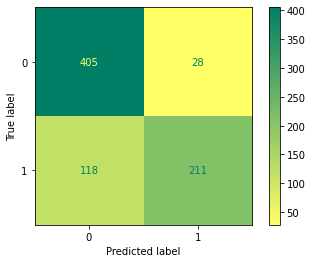

In [133]:
relatorios[0] = avaliar_modelo(previsoes[0])

In [134]:
relatorios[0]

{'acuracia': 0.8083989501312336,
 'precisao': 0.821209966257038,
 'revocacao': 0.8083989501312336,
 'pontuacao-f1': 0.8022381673606139}